<table>
<td align="center"><a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-01a-polynomial%20fitting.ipynb">
       <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab</a></td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-01a-polynomial%20fitting.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

# Running this notebook

You have two options for running this notebook - you can clone the repository to your computer and run the notebook there. That is ideal if the internet is so-so and you will work on it a bit here and a bit there. Or you can click on the Google Colab link above and run the notebook in Google Colab. To do that, you need to have a Google account, obviously you need to be online, and you need to be aware that you will have to download datafiles each time you use it (you can set it up to [load from your Google Drive](https://colab.research.google.com/notebooks/io.ipynb) if that is preferrable), and there is a time-out. However, the big advantage is that you usually do not have to install any packages which is very convenient for trying out things in class. If you do need to install a package, `astroML` is an example, then you can enter:
```
 !pip install astroML
```
in a cell (typically at the top of the notebook) and the package will be installed for you for that session.

In [1]:
import numpy as np
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
import ipywidgets as widgets

# The below is to make polyfit a bit more quiet
import warnings
warnings.simplefilter('ignore', np.RankWarning)

# A first dive into machine learning

$\newcommand{\pred}[1]{#1_{\mathrm{pred}}}$

# Accuracy and error-rate or loss function

In any machine learning situation we need to be able to quantify how well our method is working. This is done by what is known as an _error function_ or _loss function_. There are many ways one might measure the quality of a fit and they all have different strengths/advantages.

One particular family is the $L^n$ norms. If we denote the actual observed data as $y$ and the values predicted by the model as $\pred{y}$ --- the most generic version of this has an error rate function of the form
$$\epsilon = ||y-\pred{y}||_p = \left( \sum_i \left|y-\pred{y}\right|^p\right)^{1/p}$$

For $p=2$ we have arguably the most widely used norm, the least squares norm. The square of this is often used for convenience, obviously if you are looking for the minimum this is does not matter, and commonly named the mean square error (MSE): 
$$
\mathrm{MSE} = \frac{1}{N} \sum_i^N \left(y-\pred{y}\right)^2.$$

This is in general a well-behaving norm when you do not have too many outliers in your data and has nice analytic properties. Other interesting norms are the $L^1$ norm and even then $L^0$ norm which have as advantage that they will typically give \emph{sparse} solutions - where some parameters of the model are set to zero, but they are much less nice analytically so it is a trade-off.

It should be remarked that the subject of loss functions is a lot broader than I make it sound here - we will look at a few more here but I will not aim for any kind of completeness.

## Making fake data 

In order to see the use of an error function, we are first going to create some fake data. The function below takes a function as an argument. Here I will create a the data around a linear function

In [2]:
def make_fake_data(N, func, noise_scale=0.5):
  """Create fake data using a given function

  Arguments
  ---------
      N: int
         The number of data points to return
      func: function
         The function to call to get the data. This must take 
         one argument (the x-value) and return the y-value.

  Keywords
  --------
      noise_scale : float, default 0.5
         The variance of the normal distribution that is
         used to assigned random noise to the data. Set to
         zero to add no noise.

  Returns
  -------
      xvalues : numpy array
         The x-values used for calculating the data points 
      yvalues : numpy array
         The y-values, using true_func and then adding noise.
  """

  rng = np.random.default_rng()
  xvalues = rng.uniform(0, 4, N)
  yvalues = func(xvalues)+rng.normal(0, noise_scale, len(xvalues))

  return xvalues, yvalues


def show_data_func(x, y, func, xrange=None, yrange=None, ax=None):
  """A convenience function for showing data points and the true function
  
  Arguments
  ---------
      x : numpy array
          The x-values for the data
      y : numpy array
          The y-values for the data
      func : function
          The true function to overplot the data
          
  Keywords:
  ---------
      xrange : two-element array, optional
          The x-range to show.
      yrange : two-element array, optional
          The y-range to show.
      ax : matplotlib Axis object, optional
          The axis object to plot into, if not 
          provided, an axis object is created and
          returned.
  """
  xplot = np.linspace(np.min(x), np.max(x), 500)
  yplot = func(xplot)
  if (ax is None):
    fig, ax = plt.subplots(ncols=1, nrows=1)
  ax.scatter(x, y, label='Data points')
  ax.plot(xplot, yplot, label='True function', color='orange')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  if xrange is not None:
    ax.set_xlim(xrange)
  if yrange is not None:
    ax.set_ylim(yrange)

  ax.legend()


In [3]:
def linear_func(x):
    return x
    
def get_linear_data():
    xval, yval = make_fake_data(20, linear_func)
    return xval, yval

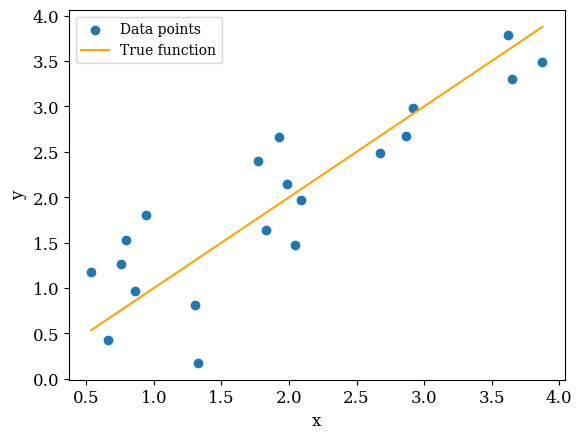

In [4]:
xl, yl = get_linear_data()
show_data_func(xl, yl, linear_func)

Now, let us define a few loss/error functions

In [5]:
# Get the Huber loss function
from scipy.special import huber

def loss_Lp(y, y_pred, p):
    """L^p loss function for p > 0"""
    if p == 0:
        print("This loss function is for p > 0 - use loss_L0 for p=0")
        return None

    if p == 1:
        z = np.sum(np.abs(y-y_pred))
    else:
        z = np.sum((y-y_pred)**p)
        
    return z**(1/p)

def loss_L0(coeffs, tol=1e-15):
    """L0 loss function - this just counts the non-zero coefficients"""

    is_zero, = np.where(np.abs(coeffs) < tol)
    loss = len(is_zero)
    return L0

def loss_10(y, y_pred, tol=1e-15):
    """0-1 loss with tolerance"""
    diff = np.abs(y-y_pred)
    
    return loss_L0(diff)

def loss_MAE(y, y_pred):
    """Median absolute error"""
    N = len(y)
    return loss_Lp(y, y_pred, 1)/N

def loss_MSE(y, y_pred):
    """Mean square error"""
    N = len(y)
    return np.sum((y-y_pred)**2)/N

def loss_Huber(y, y_pred, delta=1.0):
    """Huber loss function"""
    N = len(y)
    return np.sum(huber(delta, y-y_pred))/N


## Find the best linear fit

I am not going to find this in an efficient way - the method used below to fit a polynomial is a better choice but here we want to try different slopes.

In [6]:
def calculate_fit_to_linear(x, y, slopes=np.arange(-0.5, 2.5, 0.01), loss_function=loss_MSE):
    """Loop over the possible slopes"""

    loss = np.zeros(len(slopes))
    for i, slope in enumerate(slopes):
        y_pred = x*slope
        loss[i] = loss_function(y, y_pred)

    return slopes, loss

def show_fit(s, loss, label, ax):
    ax.plot(s, loss, label=label)
    i_min = np.argmin(loss)
    print("{0}: best slope={1:.3f}".format(label, s[i_min]))
    ax.plot(s[i_min], loss[i_min], marker='o', markersize=10)

MSE: best slope=0.980
MAE: best slope=0.930
Huber: best slope=0.980


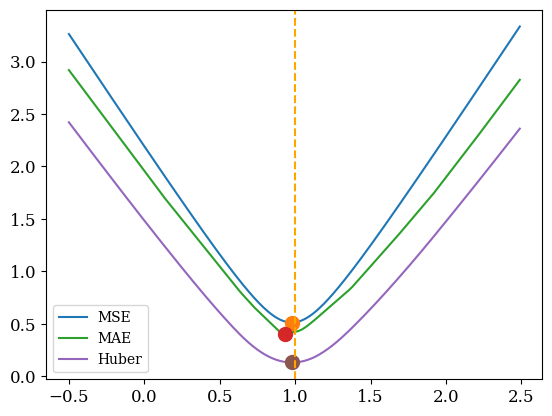

In [7]:
slopes, l_MSE = calculate_fit_to_linear(xl, yl, loss_function=loss_MSE)
slopes, l_MAE = calculate_fit_to_linear(xl, yl, loss_function=loss_MAE)
slopes, l_Huber = calculate_fit_to_linear(xl, yl, loss_function=loss_Huber)

# When comparing I take the square root of the MSE to be with similar units
fig, ax = plt.subplots(ncols=1, nrows=1)
show_fit(slopes, np.sqrt(l_MSE), 'MSE', ax)
show_fit(slopes, l_MAE, 'MAE', ax)
show_fit(slopes, l_Huber, 'Huber', ax)
ax.axvline(1.0, color='orange', ls='dashed')
plt.legend()


# A more complex set of data

That wasn't terribly interesting, so let us now define a bit more complex function to explore the complexity of the model. 

I put this into a function to later be able to modify this. I have chosen to use a type of function that is often used in introductions to this topic - a combination of a sinusoid and a linear increase, 
$$
f(x) = \sin(\pi x) + \frac{x}{3},
$$
which is defined in the function `true_func`

In [8]:
def true_func(x):
  """The true function used by `make_fake_data`"""
  return np.sin(x*np.pi)+x/3



In [9]:
x, y = make_fake_data(25, true_func)

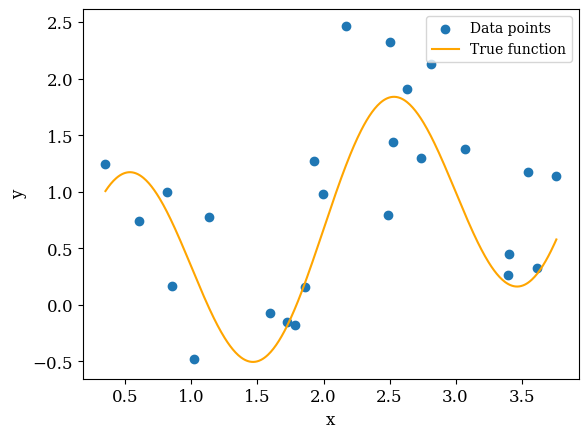

In [10]:
show_data_func(x, y, true_func)

# Fitting a seris of polynomials to the data.


## Defining the model to use

Any machine learning problem depends on specifying a model for the data. The choice of this model is problem specific and can strongly influence what you get out. Here we will use a particularly simple model - we will assume that our data are well represented by a polynomial:
$$
f(x) = \sum_{i=0}^M a_i x^i.
$$
The *parameters* of this model are the $a_i$ and when we fit the polynominal with any of the algorithms used for that, we get estimates of these $a_i$. 

However, there is another "parameter" in this equation, the maximum order of the polynomial, $M$. In many real situations we might not have any knowledge of this parameter and each $M$ creates a new model. This parameter $M$ is known as a **hyper-parameter**. Hyper-parameters come in different guises in different ML methods - here it specifies the complexity of the model. 

We do not know the value of $M$, so first we will fit a series of polynomials and see which does best.

The simplest way to assess the quality of the fit is to calculate the mean square error (MSE) and that is what we use below here.
$$
\mathrm{MSE} = \frac{1}{N} \sum_i (y_i - \mathrm{model})^2
$$

so in the function `fit_polynomials_to_xy` below, we loop over the different orders we want to try, use `polyfit` to fit a polynomial to the given data and use this to calculate the MSE for each order, in the end the orders and MSEs are returned. 

In [11]:
# We will fit up to an order of max_order with no default
def fit_polynomials_to_xy(x, y, max_order=None):
    """Fit a polynomial to input x & y data

    Parameters
    ----------
        x : numpy array
            Input x-data
        y : numpy array
            Input y-data

    Keywords
    --------
        max_order : int
            Maximum polynomial order to consider. If not given 
            this is set to the number of elements in `x`.

    Return
    ------
        orders : numpy.array
            The orders to consider
        MSE : numpy.array
            The mean square error
        best_fit: list
            A list with the polynomial coefficients of each fit.
    """
    if max_order is None:
        max_order = len(x)
    
    orders = np.arange(max_order)
    MSE = np.zeros(max_order)

    best_fit = []

    for i, order in enumerate(orders):
        # Fit the training sample using polyfit
        p = Polynomial.fit(x, y, deg=order)
        best_fit.append(p)

        # Calculate the best fit on the training sample
        mu_fit_train = p(x)
        MSE[i] = np.sum((y-mu_fit_train)**2)/len(x)

    return orders, MSE, best_fit



In [20]:
orders, MSE, best_fit = fit_polynomials_to_xy(x, y, max_order=23)

## TASK: 

Explore what happens when you increase the maximum order - is there a natural maximum order to consider? Make a plot of how MSE varies with the order

Text(0, 0.5, 'MSE')

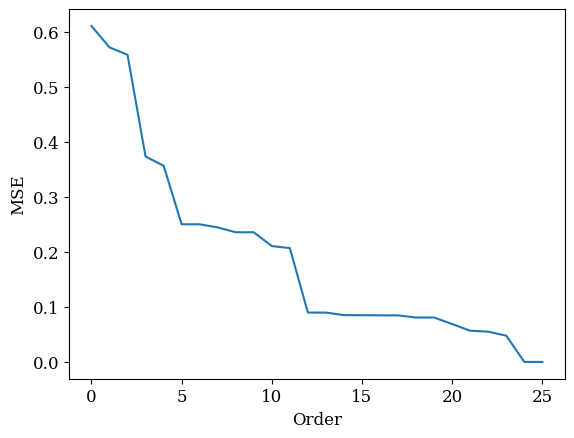

In [19]:
plt.plot(orders, MSE)
plt.xlabel('Order')
plt.ylabel('MSE')

# Summarising the polyfit

I am now assuming that you have done the task above and have at least a maximum order $>13$ - otherwise the below will not work as planned!

In [13]:
def get_extrema_and_index(x, y):
    """Find the minimum and maximum of a curve y_i=f(x_i) and return the indices as well"""

    i_min = np.argmin(y)
    i_max = np.argmax(y)

    return i_min, i_max, x[i_min], x[i_max]


In [14]:
i_min_mse_train, i_max_mse_train, min_mse_train, max_mse_train = get_extrema_and_index(orders, MSE)
print("The minimum MSE for the training sample happens for polynomial order {0}".format(min_mse_train))
print("The maximum MSE for the training sample happens for polynomial order {0}".format(max_mse_train))

The minimum MSE for the training sample happens for polynomial order 22
The maximum MSE for the training sample happens for polynomial order 0


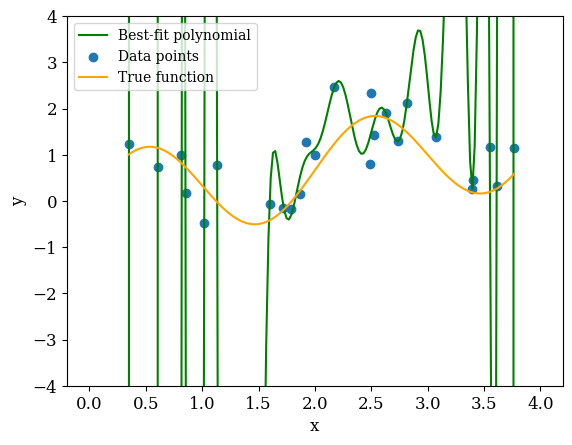

In [15]:
# We can now get the best-fitting function from the best_fit array.
x_plot = np.linspace(0, 4, 200)
p_best = best_fit[min_mse_train]
#y_fit = np.polyval(p_best, x_plot)
y_fit = p_best(x_plot)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.plot(x_plot, y_fit, label='Best-fit polynomial', color='green')
show_data_func(x, y, true_func, ax=ax, yrange=[-4, 4])

# Oops!

This clearly does not seem to match our expectations - this does not seem to fit the data well at all.

## We are now going back to the lecture for a bit.